# Classify Tumors with Machine Learning
 
This notebook explains how to use machine learning to classify tumor data. You develop your solution in three parts as follows:

* An intuitive introduction to supervised learning concepts

* A basic example of a machine learning model. 

* A deep dive into model stacking and parameter tuning, both of which are used in practice to significantly improve predictive accuracy

Some guidelines for reading this notebook:

* If you have no experience with machine learning: follow the entire notebook for a comprehensive walkthrough.

* If you would like to read about decision trees, go to [section 2](#bullet-8).

* If you would like to read about using XGBoost in practice, go to [section 3](#bullet-13).

Some familiarity with Python is recommended. This notebook runs on Python 2 with Spark 2.0.

## Table of contents
1.0 [Introduction to supervised learning](#bullet-1)<br/>
2.0 [Basic model: decision trees](#bullet-8)<br/> 
3.0 [Ensemble model: gradient boosting](#bullet-13)  
4.0 [XGBoost: parameter tuning](#bullet-17)
    

## 1.0 Introduction to supervised learning<a class="anchor" id="bullet-1"></a>

1.1 [What is machine learning?](#bullet-2)<br/>
    1.2 [Defining the task](#bullet-3)<br/>
    1.3 [How does an algorithm learn?](#bullet-4)<br/>
    1.4 [Data preview](#bullet-5)<br/>
    1.5 [Pre-processing](#bullet-6)<br/>
    1.7 [Create train and test sets](#bullet-7)<br/>

### 1.1 What is machine learning?<a class="anchor" id="bullet-2"></a>

You use an algorithm (code) to create a model (mathematical function). The algorithm tries to find patterns in a sample of **training data** that can be used on future data. The model itself is a summary of these patterns, distilled into mathematical relationships between variables. The algorithm depends on **hyperparameters** that control how it looks for these patterns (that is, how it learns). 

The difficult part is to find parameters that balance accuracy and precision of the model with its ability to generalize.

**Note:**
* Accuracy and precision of predictions depend on the complexity of the model
* Ability to generalize depends on how conservative the model is (how quickly it concludes that something is a pattern)

This balancing act is called the **bias-variance tradeoff**, because a very complex model will represent all the specific nuances of its training data, therefore failing to generalize. In the opposite case, a simple model does not pick up enough of a pattern to ensure accuracy and precision of future predictions. 

Your job* is to pick an efficient algorithm and suitable model for our data set and learning task, and fine-tune its parameters to produce a balanced model.

**apart from the arduous task of data pre-processing, which this notebook skims over for the sake of brevity (and sanity!)*


### 1.2 Defining the task<a class="anchor" id="bullet-3"></a>

The goal is to use an augmented version <a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29" target="_blank" rel="noopener noreferrer">this data set</a> to develop a predictive model which classifies breast tumors as malignant or benign depending on measurements of the tumor cells. The [augmented data set](https://apsportal.ibm.com/exchange/public/entry/view/c173693bf48aeb22e41bbe2b41d79c1f) includes statistical analysis values, such as the mean, for some of the measurements. In machine learning terms, the **target** (what you want to predict) is the diagnosis, and the **features** are the measurements. The data sample contains **observations** of tumor cases described by these two components.


### 1.3 How does an algorithm learn?<a class="anchor" id="bullet-4"></a>

1. Initialize the algorithm to produce a default model, and give it the feature data. The algorithm makes its first set of predictions (close to a random guess).
2. The algorithm measures the error between its previous prediction and the true value of the targets. 
3. The algorithm adjusts its model-building to make the error smaller. Each adjustment represents a part of the pattern it is learning, and is used to process future data.
4. It continues to predict, calculate error, and adjust.

Remember that the algorithm is only using a training sample to perform step 3. If the algorithm makes an adjustment so that its predictions are *exactly* the targets, then it is **overfitted** to the training data. This means that it has lost the ability to generalize to new (unseen) observations, because it picked up a pattern that only applies to the data points it learned from.



#### Load data
To load the data:
1. Go to the [data set](https://apsportal.ibm.com/exchange/public/entry/view/c173693bf48aeb22e41bbe2b41d79c1f) on the DSX Community. 
1. Click the download icon and save the data set to your computer.  
1. Load the `BreastCancerWisconsonDataSet.csv` file into your notebook. Click the **Find and Add Data** icon on the notebook action bar. Drop the file into the box or browse to select the file. The file is loaded to your object storage and appears in the Data Assets section of the project. For more information, see <a href="https://datascience.ibm.com/docs/content/analyze-data/load-and-access-data.html" target="_blank" rel="noopener noreferrer">Load and access data</a>.
1. To load the data from the `BreastCancerWisconsonDataSet.csv` file into a pandas DataFrame, click in the next code cell and select **Insert to code > pandas DataFrame** under the file name.
1. Make sure the object is named `df` instead of `df_data_1` in the last two lines of the **Insert to Code** block and then run the cell.

In [1]:
# The code was removed by DSX for sharing.

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 1.4 Data preview<a class="anchor" id="bullet-5"></a>

In the following data table, each row corresponds to one observation of a tumor. The columns contain the measurement features, with one column containing the diagnosis target.

In [2]:
from IPython.display import display
print df.shape
display(df[200:210])

(569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
200,877501,B,12.230,19.56,78.54,461.0,0.09586,0.08087,0.04187,0.04107,...,14.44,28.36,92.15,638.4,0.1429,0.2042,0.13770,0.10800,0.2668,0.08174
201,877989,M,17.540,19.32,115.10,951.6,0.08968,0.11980,0.10360,0.07488,...,20.42,25.84,139.50,1239.0,0.1381,0.3420,0.35080,0.19390,0.2928,0.07867
202,878796,M,23.290,26.67,158.90,1685.0,0.11410,0.20840,0.35230,0.16200,...,25.12,32.68,177.00,1986.0,0.1536,0.4167,0.78920,0.27330,0.3198,0.08762
203,87880,M,13.810,23.75,91.56,597.8,0.13230,0.17680,0.15580,0.09176,...,19.20,41.85,128.50,1153.0,0.2226,0.5209,0.46460,0.20130,0.4432,0.10860
204,87930,B,12.470,18.60,81.09,481.9,0.09965,0.10580,0.08005,0.03821,...,14.97,24.64,96.05,677.9,0.1426,0.2378,0.26710,0.10150,0.3014,0.08750
205,879523,M,15.120,16.68,98.78,716.6,0.08876,0.09588,0.07550,0.04079,...,17.77,20.24,117.70,989.5,0.1491,0.3331,0.33270,0.12520,0.3415,0.09740
206,879804,B,9.876,17.27,62.92,295.4,0.10890,0.07232,0.01756,0.01952,...,10.42,23.22,67.08,331.6,0.1415,0.1247,0.06213,0.05588,0.2989,0.07380
207,879830,M,17.010,20.26,109.70,904.3,0.08772,0.07304,0.06950,0.05390,...,19.80,25.05,130.00,1210.0,0.1111,0.1486,0.19320,0.10960,0.3275,0.06469
208,8810158,B,13.110,22.54,87.02,529.4,0.10020,0.14830,0.08705,0.05102,...,14.55,29.16,99.48,639.3,0.1349,0.4402,0.31620,0.11260,0.4128,0.10760
209,8810436,B,15.270,12.91,98.17,725.5,0.08182,0.06230,0.05892,0.03157,...,17.38,15.92,113.70,932.7,0.1222,0.2186,0.29620,0.10350,0.2320,0.07474


The data contains features extracted from 569 diagnostic images of breast tumors. The diagnosis column indicates whether the mass was benign (B), or malignant (M). The rest of the columns contain features which are structured as follows:

10 variables describe the cell nuclei of each mass, and for each variable, the mean, standard deviation, and 'worst' (mean of three largest measurements) are calculated. The variables are briefly described on the <a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29" target="_blank" rel="noopener noreferrer">original data set page</a>.


### 1.5 Pre-processing<a class="anchor" id="bullet-6"></a>

The following code cell gently cleans the data and generates a summary that can be used to check for outliers. This data set is well prepared for analysis and does not require further manipulation.

If you don't have scikit-learn library installed, install it.

In [3]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /gpfs/global_fs01/sym_shared/YPProdSpark/user/se0e-410588f53eaee3-ac63c96e2357/.local/lib/python2.7/site-packages


In [4]:
from sklearn.preprocessing import LabelEncoder

# checking for missing values
df.isnull().any()

# dropping Unnamed column
# df2 = df.drop(['Unnamed: 32'], axis=1)

df2 = df

# converting diagnosis M/B to numerical
lenc = LabelEncoder()
lenc.fit(df['diagnosis'])
df2['diagnosis'] = lenc.transform(df2['diagnosis'])

# overview of data sample
df2.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


### 1.6 Create train and test sets<a class="anchor" id="bullet-7"></a>

Take 80% of the total data to train the model, and reserve 20% of it for testing. After the model is built and tuned upon the training set, you can use the testing set to observe how well the model is able to generalize to new 'unseen' data.

In [5]:
from sklearn.model_selection import train_test_split

## X are all the features (columns) that might be useful to the model
## y is the target (diagnosis column)
X, y = df2.ix[:,'radius_mean':], df2[['diagnosis']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## 2.0 Basic model: decision trees<a class="anchor" id="bullet-8"></a>

2.1 [Mimicking human decision-making](#bullet-9)<br/>
    2.2 [Interpreting a tree graphic](#bullet-10)<br/>
    2.3 [How a decision tree learns](#bullet-11)<br/>
    2.3 [Evaluating the model](#bullet-12)<br/>

### 2.1 Mimicking human decision-making<a class="anchor" id="bullet-9"></a>

A decision tree is an algorithm that can be used for machine learning. It is analogous to the game <a href="http://www.wikihow.com/Play-20-Questions" target="_blank" rel="noopener noreferrer">20 questions</a> - each 'question' is a **splitting feature** chosen from the data based on how useful it is for identifying the target. The algorithm decides on these features by optimizing a variety of mathematical functions that quantify prediction error (<a href="https://en.wikipedia.org/wiki/Decision_tree_learning#Metrics" target="_blank" rel="noopener noreferrer">for the curious</a>).

Trees are considered weak learners, because their predictions are usually only slightly better than chance. The following code builds a tree based on the tumor data, and displays the process graphically.

If you don't have pydotplus library installed, install it.

In [6]:
!pip install pydotplus

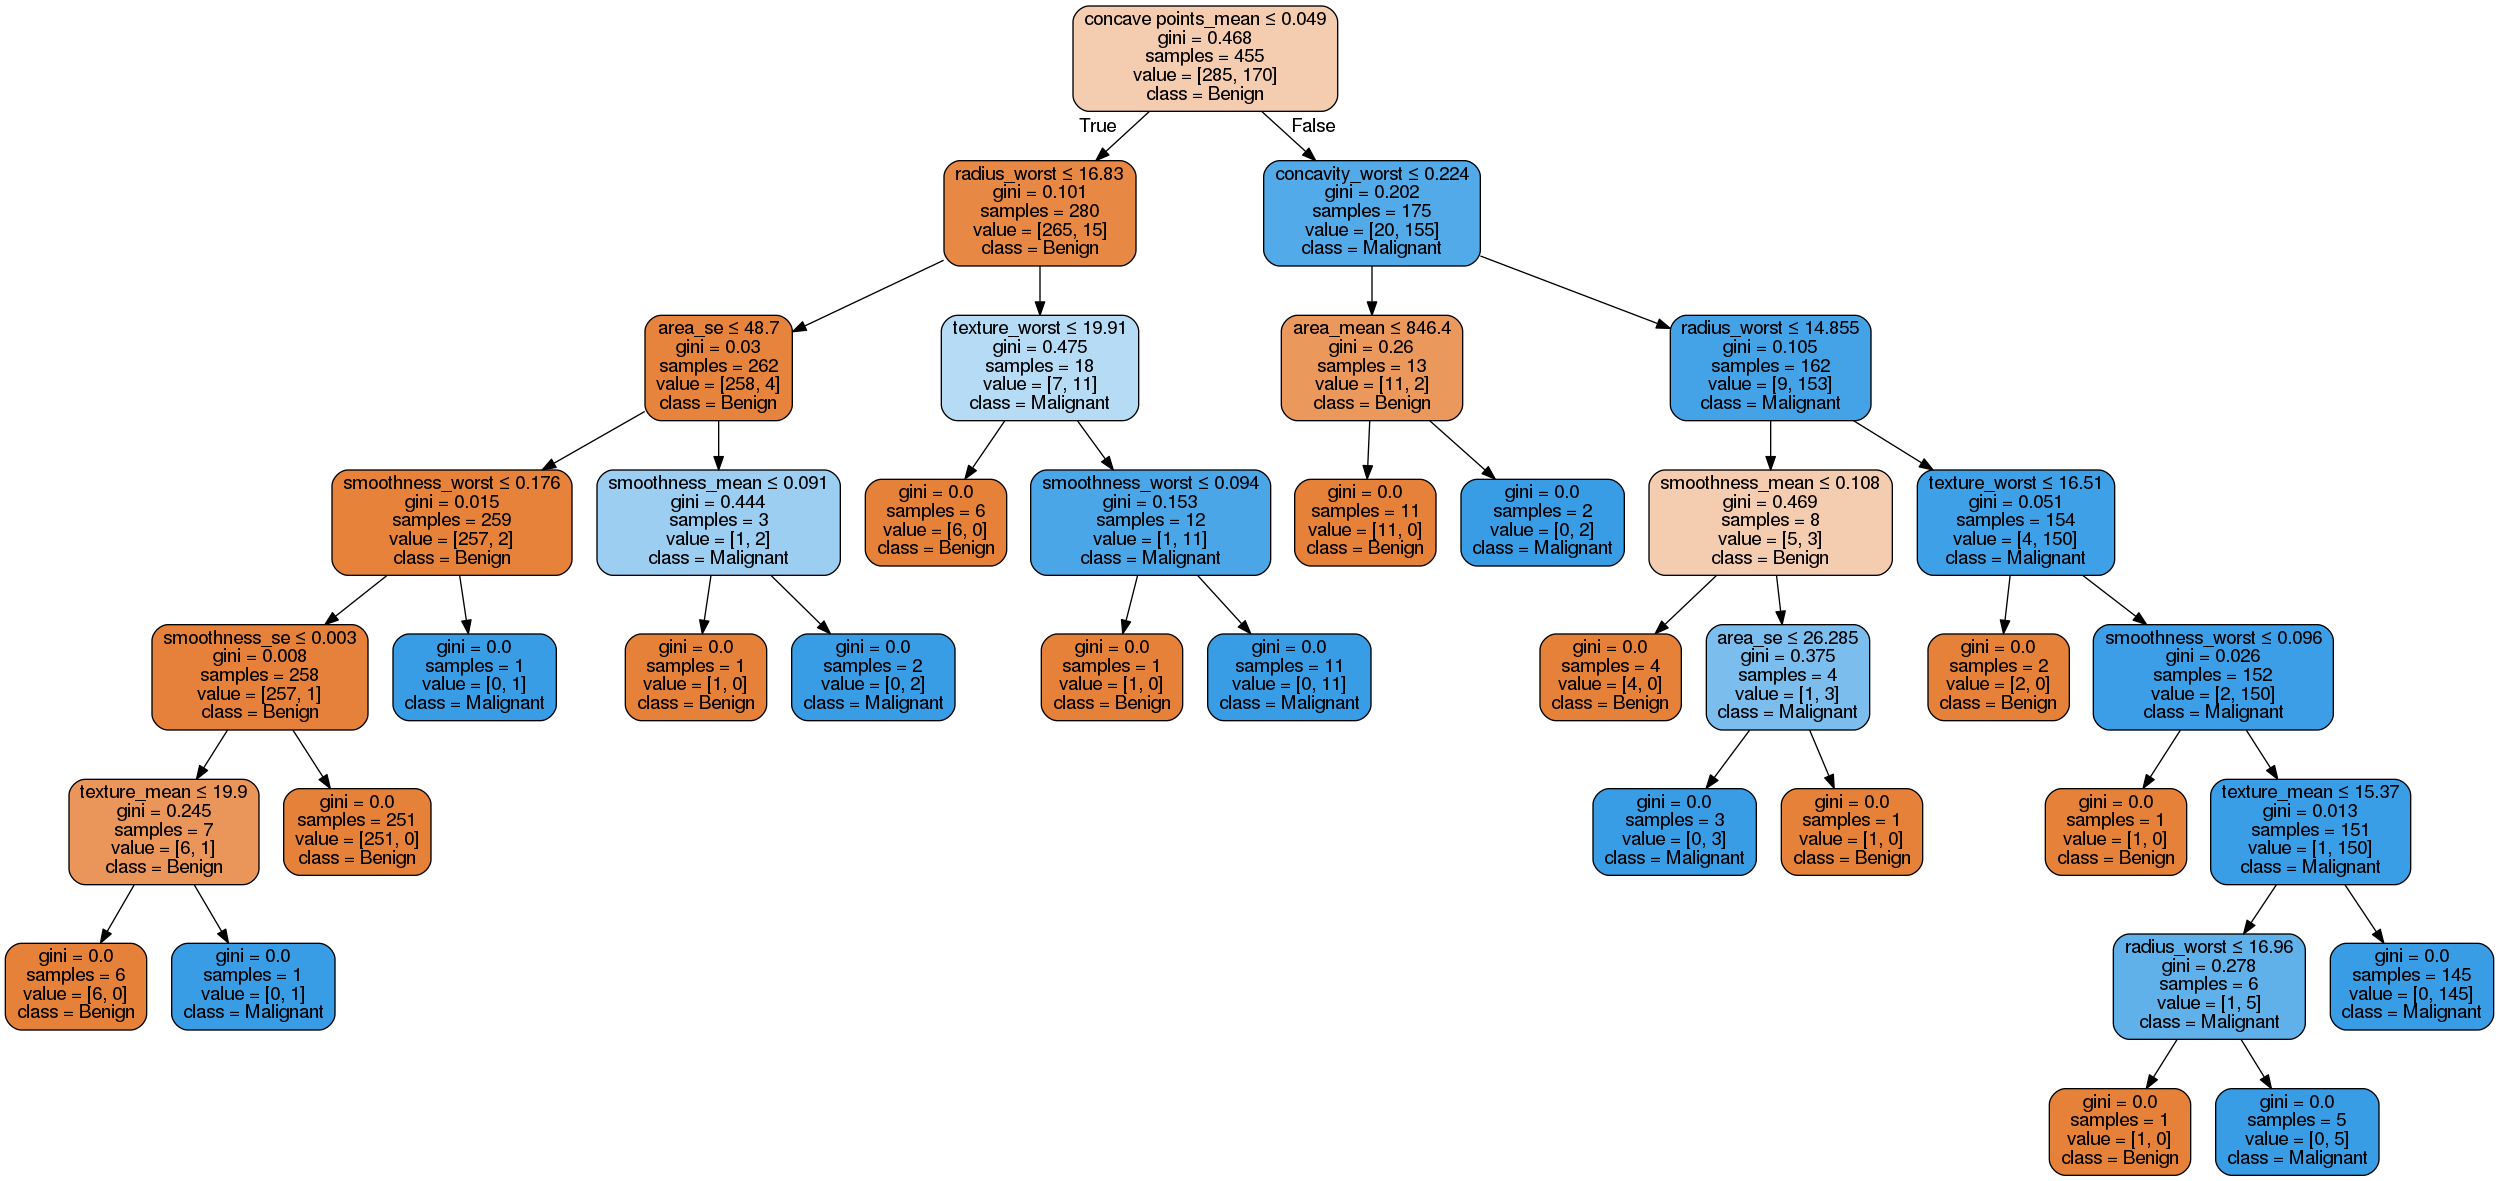

In [7]:
from sklearn import tree
import pydotplus
from IPython.display import Image 

# list of features we want to consider
splitting_features = [x for x in X_train.columns if x not in ['id']]

# initializing the tree model and training it
tree_model = tree.DecisionTreeClassifier()
tree_model = tree_model.fit(X_train, y_train)

# generating a graphic for the tree
dot_data = tree.export_graphviz(tree_model, out_file=None, 
                         feature_names=splitting_features,
                         class_names = ['Benign', 'Malignant'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

### 2.2 Interpreting a tree graphic<a class="anchor" id="bullet-10"></a>
Each rectangle represents a **node** of the tree.
* The first line in each node identifies the splitting feature and decision being made upon it.
* The observations are separated based on this decision into **children** nodes (left and right).
* **Samples**: how many observations have been filtered by that decision.
* **Value**: where how many observations are being split into the left and right children respectively.
* **Gini**: a measurement of incorrect classification. As the algorithm learns, the gini inequality decreases to 0.
* **Class**: the target that the observations have been grouped into: benign or malignant.
* The rectangles at the bottom of the diagram are called **leaves**, which contain the final predictions (observations classified by diagnosis).

### 2.3 How a decision tree learns<a class="anchor" id="bullet-11"></a>

Applying the general learning outline ([section 1.3](#bullet-4)) to a decision tree:

*1. Initialize the algorithm to produce a default model, and give it the feature data. The algorithm makes its first set of predictions (close to a random guess).*<br/>
The default model is the very first splitting feature - the algorithm chose 'concave points mean <= 0.0492'. The observations are divided into benign or malignant based on this decision, making up the first set of predictions!

*2. The algorithm measures the error between its previous prediction and the true value of the targets.*<br/> 
This error is quantified by the gini value that appears in the first node of the tree.

*3. The algorithm adjusts its model-building to make the error smaller. Each adjustment represents a part of the pattern it is learning, and is used to process future data.*<br/>
The adjustment is the next splitting feature that is chosen for each subgroup that resulted from the concave points mean decision. The algorithm chose 'radius worst' for observations that had a concave points mean less than the threshold, and 'concavity worst' for observations with concave points mean greater than the threshold.

*4. It continues to predict, calculate error, and adjust.*<br/>
The next set of predictions are the classifications that result from the second round of decision making. Each time, a gini value is calculated to indicate how far the classifications are from the true targets, and another set of splitting features are chosen to further refine the class groupings. 

### 2.4 Evaluating the model<a class="anchor" id="bullet-12"></a>
Pick a metric to measure predictive accuracy or performance of your model, so that you can compare different models. 

Models can differ in two ways:

1. The algorithm used for learning (for example, the difference between a decision tree and gradient boosting)
2. The **parameter** selection within a single algorithm (for example, a model with a learning rate set to 0.1 or 0.0)

This case refers to (1), you want to know how the tree model performs, so that it can be compared to the gradient boosting model in the next section.

The choice of evaluation metric depends on the type of learning problem. For binary classification, you can use a metric called the <a href="https://www.quora.com/Machine-Learning-What-is-an-intuitive-explanation-of-AUC" target="_blank" rel="noopener noreferrer">AUC score</a>, which measures the probability that the model correctly identifies *malignant tumors only*. This metric is used as an indication of performance because misclassifying a malignant tumor as benign is the worst prediction scenario (compared to correct classification of benign/malignant and misclassification of benign).

You also calculate the general accuracy of the model - the percentage of observations that have been correctly classified overall. The following code uses your simple tree model to predict on the testing set, and evaluates the accuracy and AUC score of its predictions:

In [8]:
from sklearn import metrics

#Predict test set:
test_predictions = tree_model.predict(X_test[splitting_features])
test_predprob = tree_model.predict_proba(X_test[splitting_features])[:,1]
        
#Print model report:
print "Accuracy : %.4g" % metrics.accuracy_score(y_test['diagnosis'].values, test_predictions)
print "AUC Score: %f" % metrics.roc_auc_score(y_test['diagnosis'], test_predprob)

Accuracy : 0.9298
AUC Score: 0.934524


The model gives ~92% accuracy for all cases, and a ~93% probability of catching malignant cases in the data. Each time the code is run, the algorithm may learn slightly differently (that is, select different splitting features), which results in slight variations in accuracy and AUC scores. In the following section, you work on improving the model by stacking together many trees, and tuning parameters for better generalization ability.

## 3.0 Ensemble model: gradient tree boosting<a class="anchor" id="bullet-13"></a>

Stacking, or meta-ensembling, is a method of joining multiple predictive models so that the strengths of each can cover the weaknesses of others. Gradient boosting is one technique used to stack weak learners together in an **ensemble** to achieve better predictions with each additional model.

3.1 [An intuitive explanation](#bullet-14)<br/>
    3.2 [XGBoost](#bullet-15)<br/>
    3.3 [K-fold cross validation](#bullet-16)<br/>

### 3.1 An intuitive explanation of gradient boosting<a class="anchor" id="bullet-14"></a>

1. A tree is used to learn from the data as described in [section 2.2](#bullet-10). This first model is called the **base learner**.
2. The algorithm calculates the error of the base learner's final predictions. These error measurements are called **pseudo-residuals**. 
3. A second decision tree, called the **booster**, is stacked on top of the base tree by using the pseudo-residuals as input. Its output is a prediction of error for each prediction of the base tree. 
4. The algorithm adjusts the base prediction by adding the predicted amount of error.
*Note: target - prediction = error, so by adding 'predicted error' to the base prediction, you are getting closer to the target.*
5. Another set of pseudo-residuals are calculated for the predictions of the updated model (base tree + first boosting tree). Each round of boosting corrects the base prediction by a predicted amount of error, gradually inching towards the true value.


### 3.2 XGBoost<a class="anchor" id="bullet-15"></a>

You use the XGBoost library, an implementation of gradient tree boosting popularized by usage in machine learning competitions. It is a valuable addition to any machine learning toolkit, as it significantly outperforms other algorithms in speed, accuracy, and flexibility. 

If you don't have xgboost library installed, install it.

In [9]:
!pip install xgboost

**Note:** The xgboost package uses an older version of sklearn. When you run import xgboost, ignore the DeprecationWarning. 

In [10]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

/gpfs/fs01/user/se0e-410588f53eaee3-ac63c96e2357/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 3.3 K-fold cross validation<a class="anchor" id="bullet-16"></a>

Cross-validation is used to measure how well a model generalizes using the training set (no need to bring in the testing set yet!). The k-fold method divides the training data into even smaller train/test sets to gauge how the model performs on 'unseen' data.

1. The data is divided into k subsamples. You use 5 subsamples: you can call them A, B, C, D, E.
2. The model is trained on 4 subsamples (for example, A, B, C, D).
3. The model makes predictions on the subsample that was held out from training (E), and you score it based on an evaluation metric.
4. The model is then trained on another combination of subsamples (for example, B, C, D, E), and tested on the one that was held out (A).
5. This repeats for every possible combination of k-folds. You take the average of the evaluation metrics at each iteration to give an idea of how the model performs on actual unseen data.

You use cross-validation during parameter tuning so that you can directly observe the effect of a parameter on a model's generalization ability.

In [11]:
from sklearn import cross_validation

## 4.0 XGBoost: Parameter tuning<a class="anchor" id="bullet-17"></a><a href="#footnote-1"><sup>[1]</sup></a>

4.1 [Default model](#bullet-18)<br/>
    4.2 [Tuning number of estimators](#bullet-19)<br/>
    4.3 [Evaluating default model](#bullet-20)<br/>
    4.4 [Interpreting evaluation](#bullet-21)<br/>
    4.5 [Grid search](#bullet-22)<br/>
    4.6 [Tuning tree depth and min child weight](#bullet-23)<br/>
    4.7 [Tuning gamma](#bullet-24)<br/>
    4.8 [Evaluating updated model](#bullet-25)<br/>
    4.9 [Tuning sampling parameters](#bullet-26)<br/>
    4.10 [Tuning lambda & alpha](#bullet-27)<br/>
    4.11 [Evaluating final model](#bullet-28)<br/>
    4.12 [Predict on the test set](#bullet-29)<br/>

### 4.1 Setting up a default model<a class="anchor" id="bullet-18"></a>
You need to initialize a model with some default parameters as a starting point. The selection here depends on the nature of your data and your experience. Recall that parameters tell the algorithm how to learn in one of two ways: how complex the model will be, and how quickly it should conclude on a pattern in the data.

Luckily, XGBoost performs well with its default values, so you only need to define the following three parameters: 

1. objective: Depends on the target type - use binary:logistic because you have a binary classification problem.
2. learning rate: This parameter is always chosen first, as the optimal values of all other parameters are dependent upon it. It directly controls how conservative the model is in picking up patterns - a smaller value makes the model more conservative. A good rule of thumb is to initialize the learning rate at 0.1.  
3. number of estimators: The maximum number of boosting trees to be added. Pick a number that is a bit larger than necessary for our data set size. 


In [12]:
# initializing our first model with an objective and learning rate
xgb0 = XGBClassifier(
 objective= 'binary:logistic',
 learning_rate = 0.1, 
 n_estimators = 30)

### 4.2 Tuning number of estimators<a class="anchor" id="bullet-19"></a>

The 'number of estimators' parameter in XGBoost refers to the maximum number of boosting trees (or rounds) to be used in building the model. Intuitively, the more trees that are added to the model, the more complex it is. This parameter is tuned first, so you can broadly adjust the complexity of your model before making adjustments that have smaller impacts on conservative learning.

The function below performs the following actions to find the best number of boosting trees to use on your data:

1. Trains an XGBoost model using features of the data.
2. Performs k-fold cross validation on the model, using accuracy and AUC score as the evaluation metric.
3. Returns output for each boosting round so you can see how the model is learning. You will look at the detailed output in the next section.
4. It stops running after the cross-validation score does not improve significantly with additional boosting rounds, giving you an optimal number of estimators for the model.

In [13]:
import matplotlib.pylab as plt
%matplotlib inline

def evaluate_model(alg, train, target, predictors, cv_folds=5, early_stopping_rounds=1):
    
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(train[predictors].values, target['diagnosis'].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
    alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(train[predictors], target['diagnosis'], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(train[predictors])
    dtrain_predprob = alg.predict_proba(train[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(target['diagnosis'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(target['diagnosis'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importance', color='g')
    plt.ylabel('Feature Importance Score')

### 4.3 Evaluating the default model<a class="anchor" id="bullet-20"></a>

[0]	train-auc:0.990438+0.0043441	test-auc:0.926124+0.0308149
[1]	train-auc:0.992888+0.00468617	test-auc:0.931389+0.0268596
[2]	train-auc:0.994384+0.00415501	test-auc:0.940164+0.0247549
[3]	train-auc:0.995703+0.0039396	test-auc:0.951798+0.0179173
[4]	train-auc:0.996562+0.00337873	test-auc:0.960113+0.0179518
[5]	train-auc:0.996743+0.00331955	test-auc:0.960803+0.0173276
[6]	train-auc:0.998216+0.00189801	test-auc:0.969066+0.0193102
[7]	train-auc:0.99837+0.0017634	test-auc:0.969424+0.0195996
[8]	train-auc:0.999067+0.000526675	test-auc:0.976554+0.012878
[9]	train-auc:0.999073+0.000534526	test-auc:0.980293+0.0127638

Model Report
Accuracy : 0.9824
AUC Score (Train): 0.998772


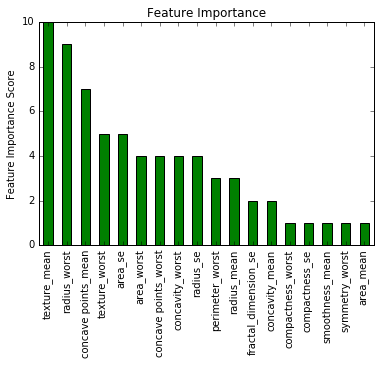

In [14]:
# a list of features to be used for training the model
features = [x for x in X_train.columns if x not in ['id']]

# evaluating the first model
evaluate_model(xgb0, X_train, y_train, features)

### 4.4 Interpreting evaluation output<a class="anchor" id="bullet-21"></a>

* The first set of readings shows you the cross-validation scores at each boosting round. So at line [0], one tree has been fit to the data. Train-auc gives you the average AUC score for the five training sets during cross-validation, and test-auc gives you the same metric for the five testing sets during cross validation. Naturally, the test score is lower, as the model is predicting on data that was not used to train it. You can see that the test-auc catches up with more boosting rounds, as more trees are used to minimize the error.
<br/><br/>
* The model stops training after ten rounds, which means that the cross-validation scores are not significantly improving with more than 10 rounds. For a learning rate of 0.1, you can take the number of estimators to be 10 to save computation time.
<br/><br/>
* Overall, the accuracy is 0.9824, which tells you how many cases were correctly classified, both benign and malignant.
<br/><br/>
* Overall, the AUC score is 0.99877, which indicates that the model rarely lets malignant cases slip through its screening process.
<br/><br/>
* The graph displays the features ranked by their importance to the model. Feature importance refers to the number of times it is used as a splitting feature in the decision trees. This function is especially useful in large datasets, where many variables are just noise and <a href="https://en.wikipedia.org/wiki/Feature_engineering" target="_blank" rel="noopener no referrer">feature engineering</a> may be required.

### 4.5 Grid search<a class="anchor" id="bullet-22"></a>
To tune the remaining XGBoost parameters, use grid search with cross-validation.

1. Define set of values for the parameter in question. These values of interest again depend on the nature of the data and your experience.
2. The grid search function systematically produces a model for each unique combination of these values, and evaluates it using cross-validation.
3. The optimal parameter values are found in the model with the highest cv score.

In [15]:
from sklearn.model_selection import GridSearchCV

### 4.6 Tuning max depth and child weight<a class="anchor" id="bullet-23"></a>

**max depth**: The size of each new decision tree. Smaller trees = less complexity. <br/>
**min child weight**: The minimum number of observations that must be in the children after a split. Smaller weight = more conservative.

In [16]:
# updating our default model with the optimal number of estimators
xgb1 = XGBClassifier(
 objective = 'binary:logistic',
 learning_rate =0.1,
 n_estimators=10)

# array of values for max_depth and min_child_weight parameters
param_test1 = {'max_depth':range(3,7,1),'min_child_weight':range(1,3,1)}

# grid search with cross-validation using the updated model and parameter value array 
gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, scoring='roc_auc',iid=False, cv=5)
gsearch1.fit(X_train[features],y_train['diagnosis'])
gsearch1.cv_results_['params'], gsearch1.best_params_, gsearch1.best_score_

([{'max_depth': 3, 'min_child_weight': 1},
  {'max_depth': 3, 'min_child_weight': 2},
  {'max_depth': 4, 'min_child_weight': 1},
  {'max_depth': 4, 'min_child_weight': 2},
  {'max_depth': 5, 'min_child_weight': 1},
  {'max_depth': 5, 'min_child_weight': 2},
  {'max_depth': 6, 'min_child_weight': 1},
  {'max_depth': 6, 'min_child_weight': 2}],
 {'max_depth': 5, 'min_child_weight': 2},
 0.98292053663570678)

The grid search found that the model works best with a max depth of 5, and a minimum child weight of 2. You can update our model accordingly and continue tuning.

### 4.7 Tuning gamma<a class="anchor" id="bullet-24"></a>
Increasing gamma makes the algorithm more conservative (less prone to overfitting).

In [17]:
# updating our current model with the max_depth and min_child weight parameter values found in last grid search
xgb2 = XGBClassifier(
 objective='binary:logistic',
 learning_rate =0.1,
 n_estimators=10,
 max_depth=5,
 min_child_weight=2,
 gamma=0)

# array of values for the gamma parameter
gamma_test = {'gamma':[i/100.0 for i in range(0,6)]}

# grid search with cross-validation using the updated model and gamma value array 
gsearch2 = GridSearchCV(estimator = xgb2, param_grid = gamma_test, scoring='roc_auc',iid=False, cv=5)
gsearch2.fit(X_train[features],y_train['diagnosis'])
gsearch2.cv_results_['params'], gsearch2.best_params_, gsearch2.best_score_

([{'gamma': 0.0},
  {'gamma': 0.01},
  {'gamma': 0.02},
  {'gamma': 0.03},
  {'gamma': 0.04},
  {'gamma': 0.05}],
 {'gamma': 0.03},
 0.98323013415892646)

The grid search found that the model works best when gamma is 0.03.

### 4.8 Evaluating updated model<a class="anchor" id="bullet-25"></a>

Revisit your evaluation function to see if you need to update the number of boosting rounds. Use the parameter values found for max_depth, min_child_weight, and gamma, and set the number of estimators as 30 to see when it stops running.

[0]	train-auc:0.991262+0.00415659	test-auc:0.946294+0.0345051
[1]	train-auc:0.994621+0.00305501	test-auc:0.957756+0.0276168
[2]	train-auc:0.995222+0.00271398	test-auc:0.959676+0.0263217
[3]	train-auc:0.996267+0.00253939	test-auc:0.964516+0.0208037
[4]	train-auc:0.997576+0.00194061	test-auc:0.971918+0.0146403
[5]	train-auc:0.998328+0.000817829	test-auc:0.973667+0.0151064
[6]	train-auc:0.998653+0.000721709	test-auc:0.977446+0.0136371
[7]	train-auc:0.998747+0.000665641	test-auc:0.978145+0.0139851
[8]	train-auc:0.998826+0.00072572	test-auc:0.979183+0.0134154
[9]	train-auc:0.999054+0.000430744	test-auc:0.98039+0.013054
[10]	train-auc:0.999119+0.000471885	test-auc:0.980871+0.0135194
[11]	train-auc:0.999183+0.000410013	test-auc:0.981016+0.0137015
[12]	train-auc:0.999287+0.000328012	test-auc:0.981277+0.0140524
[13]	train-auc:0.999364+0.000266412	test-auc:0.982261+0.0137598
[14]	train-auc:0.999358+0.000267429	test-auc:0.982305+0.0138369
[15]	train-auc:0.999383+0.000249224	test-auc:0.982511+0.01

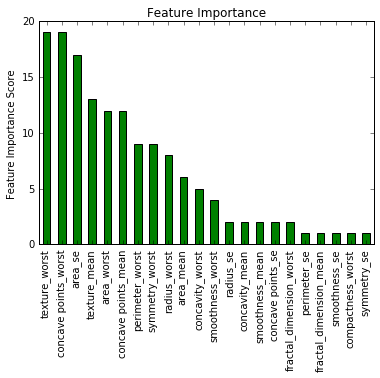

In [ ]:
xgb_check = XGBClassifier(
 objective='binary:logistic',
 learning_rate =0.1,
 n_estimators=30,
 max_depth=5,
 min_child_weight=2,
 gamma=0.03)

evaluate_model(xgb_check, X_train, y_train, features)

### 4.9 Tuning sampling parameters<a class="anchor" id="bullet-26"></a>

**subsample**: The ratio of data that is randomly selected for growing trees<br/>
**colsample_bytree**: The ratio of the subsample from which the algorithm selects splitting features

**Note:** You have reduced your data set several times now; originally, you divided it into 80/20 train and test sets. You input only the training set to XGBoost, which are segmented twice more by subsample and colsample. Perhaps less than 50% of the original data will be used to train the model, reducing the chance of overfitting and improving the model's ability to generalize. It is one of the reasons why you see a better test score for XGBoost compared to the single decision tree model. 

In [ ]:
# updating our current model with the most recent n_estimators
xgb3 = XGBClassifier(
 objective='binary:logistic',
 learning_rate =0.1,
 n_estimators=23,
 max_depth=5,
 min_child_weight=2,
 gamma=0.03)

# array of values for subsample and colsample_bytree parameters
sample_test = {
 'subsample':[i/10.0 for i in range(5,9)],
 'colsample_bytree':[i/10.0 for i in range(5,9)]
}

# grid search with cross validation for sampling parameters
gsearch3 = GridSearchCV(estimator = xgb3, param_grid = sample_test, scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(X_train[features],y_train['diagnosis'])
gsearch3.cv_results_['params'], gsearch3.best_params_, gsearch3.best_score_

The grid search found that the model works best with a colsample_bytree of 0.5, and a subsample of 0.7.

### 4.10 Tuning lambda and alpha<a class="anchor" id="bullet-27"></a>

Lambda and alpha are both regularization parameters, which mathematically reduce the impact of features that might be too dominant in the model. The difference between the two is in how they apply these penalties.

**lambda**: Applies L2 regularization, which shrinks the weights of all selected features equally. The default value is 0. <br/>
**alpha**: Applies L1 regularization, which can shrink the weights down to 0 - essentially discarding features that have little impact on the model. The default is 1.

These parameters have more significant effects on large models (with more features). Tune them to see how it impacts your model.

In [ ]:
# updating our current model with the sampling parameters found in the last grid search
xgb4 = XGBClassifier(
 objective='binary:logistic',
 learning_rate =0.1,
 n_estimators=23,
 max_depth=5,
 min_child_weight=2,
 gamma=0.03, 
 subsample=0.7,
 colsample_bytree=0.5)

# array of values for subsample and colsample_bytree parameters
reg_test = {'reg_alpha':[0, 0.01, 0.1], 'reg_lambda':[1, 1.1, 1.2, 1.3]}

# grid search with cross validation for regularization parameters
gsearch4 = GridSearchCV(estimator = xgb4, param_grid = reg_test, scoring='roc_auc',iid=False, cv=5)
gsearch4.fit(X_train[features],y_train['diagnosis'])
gsearch4.cv_results_['params'], gsearch4.best_params_, gsearch4.best_score_

The grid search found that the model works best when the reg_alpha regualization is 0.01 and the reg_lambda regulization is 1.

### 4.11 Evaluating final model<a class="anchor" id="bullet-28"></a>
Run the current model through your evaluation function a final time. Compared to the model with default parameters, tuning has improved accuracy from 0.9824 to 0.9912, and the AUC score from 0.998772 to 0.999195. You can see why XGBoost is most popular for competition use, where those fourth decimal places really count!

In [ ]:
# updated model with alpha value found with last grid search. (lambda does not need to be set, since default is 1)
xgb_final = XGBClassifier(
 objective='binary:logistic',
 learning_rate =0.1,
 n_estimators=30,
 max_depth=5,
 min_child_weight=2,
 gamma=0.03,
 reg_alpha=0.01)

evaluate_model(xgb_final, X_train, y_train, features)

### 4.12 Predict on the test set<a class="anchor" id="bullet-29"></a>
Finally, predict on the test data you reserved at the beginning. The XGBoost ensemble gives you approximately a 3% increase in accuracy and a 5% increase in AUC score over a single decision tree.

In [ ]:
test_features = [x for x in X_test.columns if x not in ['id']]

#Predict test set:
test_predictions = xgb_final.predict(X_test[test_features])
test_predprob = xgb_final.predict_proba(X_test[test_features])[:,1]
        
#Print model report:
print "Accuracy : %.4g" % metrics.accuracy_score(y_test['diagnosis'].values, test_predictions)
print "AUC Score (Test): %f" % metrics.roc_auc_score(y_test['diagnosis'], test_predprob)

If you want to increase the accuracy and AUC score even further, you can restart the parameter tuning process with a smaller learning rate. The next value to try is 0.01. 

## Summary
You've found out how to use a decision tree as a machine learning model to classify cancer data, and you've seen how you how tools like XGBoost can be used to tune parameters to improve the accuracy of your model.

### Learn more:
* <p id="footnote-1"><sup>[1]</sup><a id="fn1" href="https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python" target="_blank" rel="noopener noreferrer">Jain, A. (March 1, 2016) Complete Guide to Parameter Tuning in XGBoost(with codes in Python)</a>
* <a href="https://en.wikipedia.org/wiki/Feature_engineering" target="_blank" rel="noopener no referrer">Feature engineering</a>
* <a href="https://en.wikipedia.org/wiki/Decision_tree_learning#Metrics" target="_blank" rel="noopener noreferrer">Decision tree learning metrics</a>
* <a href="https://www.quora.com/Machine-Learning-What-is-an-intuitive-explanation-of-AUC" rel="noopener noreferrer">An intuitive explanation of AUC</a>
* <a href="http://www.wikihow.com/Play-20-Questions" target="_blank" rel="noopener noreferrer">How to play 20 questions</a>


### Author
Natalie Ho studies statistics at the University of Waterloo.

### Data citations

<p id="footnote-2"> Lichman, M. (2013). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science. <a id="fn2"></a>

Copyright © IBM Corp. 2017. This notebook and its source code are released under the terms of the MIT License.